# Fraud Detection

## Dataset exploration

### [Dataset](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data) Description: Fraudulent Transactions Prediction

### Context  
The dataset supports the development of a model to predict fraudulent transactions for a financial company. Insights derived from the model are intended to inform an actionable plan. The data is in CSV format, containing **6,362,620 rows** and **10 columns**, simulating 30 days of transactions.

### Content  
The dataset includes the following features:

- **`step`**: Time unit in hours (1 step = 1 hour, total steps = 744).
- **`type`**: Type of transaction - `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`.
- **`amount`**: Transaction amount in local currency.
- **`nameOrig`**: Customer initiating the transaction.
- **`oldbalanceOrg`**: Initial balance of the sender before the transaction.
- **`newbalanceOrig`**: New balance of the sender after the transaction.
- **`nameDest`**: Recipient of the transaction.
- **`oldbalanceDest`**: Initial balance of the recipient before the transaction (missing for merchants, indicated by names starting with "M").
- **`newbalanceDest`**: New balance of the recipient after the transaction (missing for merchants).
- **`isFraud`**: Indicates if the transaction was fraudulent (simulated fraudulent behavior involves taking control of accounts to transfer and withdraw funds).
- **`isFlaggedFraud`**: Flags illegal attempts, defined as transferring amounts exceeding 200,000 in a single transaction.

### Inspiration  
The dataset enables analysis and answering of key questions, including:

- Data cleaning to address missing values, outliers, and multi-collinearity.
- Elaboration on the fraud detection model and variable selection process.
- Evaluation of model performance using appropriate tools.
- Identification of key predictors for fraudulent transactions.
- Logical analysis of the predictive factors.
- Recommendations for prevention strategies to enhance infrastructure security.
- Measurement of the effectiveness of implemented actions.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('raw_data/Fraud.csv')

print(f"Shape: {data.shape}")
data.head(3)

Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [3]:
# Checking for null values
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Check for class imbalance
non_fraudulent = len(data[data['isFraud'] == 0])
fraudulent = len(data[data['isFraud'] == 1])

non_fraudulent_perc = np.round(non_fraudulent/data.shape[0], decimals=4)
fraudulent_perc = np.round(fraudulent/data.shape[0], decimals=4)

print(f"Non-fraudulent transactions: {non_fraudulent}\nFraudulent transactions: {fraudulent}")

print("_"*100)

print(f"Non-fraudulent transactions: {non_fraudulent_perc}\nFraudulent transactions: {fraudulent_perc}")

Non-fraudulent transactions: 6354407
Fraudulent transactions: 8213
____________________________________________________________________________________________________
Non-fraudulent transactions: 0.9987
Fraudulent transactions: 0.0013


In [6]:
# Checking if all FlaggedFrauds are classified as 1 in isFrauds column
assert len(data[(data['isFlaggedFraud'] == 1) & (data['isFraud'] == 1)]) == len(data[data['isFlaggedFraud'] == 1])

In [9]:
for col in ['type', '']:
    print(data[col].unique)

<bound method Series.unique of 0            1
1            1
2            1
3            1
4            1
          ... 
6362615    743
6362616    743
6362617    743
6362618    743
6362619    743
Name: step, Length: 6362620, dtype: int64>
<bound method Series.unique of 0           PAYMENT
1           PAYMENT
2          TRANSFER
3          CASH_OUT
4           PAYMENT
             ...   
6362615    CASH_OUT
6362616    TRANSFER
6362617    CASH_OUT
6362618    TRANSFER
6362619    CASH_OUT
Name: type, Length: 6362620, dtype: object>
<bound method Series.unique of 0             9839.64
1             1864.28
2              181.00
3              181.00
4            11668.14
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: amount, Length: 6362620, dtype: float64>
<bound method Series.unique of 0          C1231006815
1          C1666544295
2          C1305486145
3           C840083671
4          C2048537720


### EDA

In [23]:
def plot_isfraud_value_count(data : pd.DataFrame) -> None:
    """
    Plots a bar chart showing the counts of unique values in the 'isFraud' column of a DataFrame.

    This function creates a bar plot using Seaborn to visualize the distribution of values (0 and 1)
    in the 'isFraud' column of the given DataFrame. The chart includes:
    - Custom annotations above each bar displaying the exact count.
    - Customized y-axis tick labels for better readability.
    - A title and axis labels for clarity.

    Parameters:
    -----------
    data : pd.DataFrame
        A pandas DataFrame containing the 'isFraud' column with binary values (0 and 1).

    Returns:
    --------
    None
        This function displays the plot but does not return any value.

    Notes:
    ------
    - The function assumes the 'isFraud' column exists in the DataFrame and contains binary values.
    - The y-axis tick intervals are set to 1,000,000 by default and may require adjustment for datasets
      with smaller counts.
    """
    value_counts = data['isFraud'].value_counts()

    ax = sns.barplot(x=value_counts.index, y=value_counts.values, color='maroon')

    for index, value in enumerate(value_counts.values):
        ax.text(index, value + max(value_counts.values) * 0.02,
                str(value),
                ha='center', fontsize=12, fontweight='bold')

    ax.set_yticks(range(0, max(value_counts.values) + 1, 1000000))
    ax.set_yticklabels([f"{tick}" for tick in ax.get_yticks()])
    plt.xlabel('isFraud')
    plt.ylabel('Count')
    plt.title('Value count in isFraud Column')
    plt.ylim(0, max(value_counts.values) * 1.1)
    plt.show()

    return None

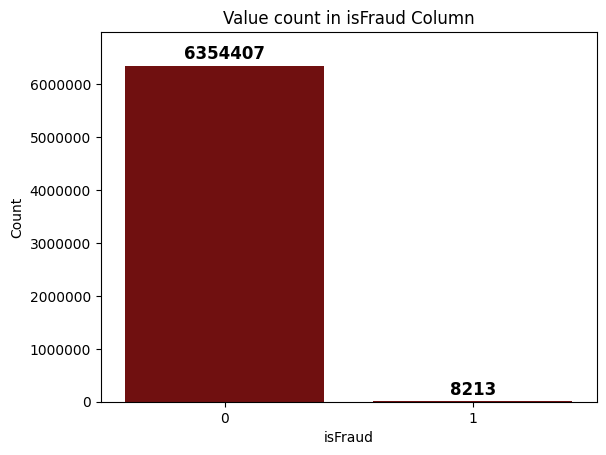

In [24]:
plot_isfraud_value_count(data)

In [8]:
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

x_fraction = 0.3

for i, col in enumerate(numeric_columns):
    x_max = data[col].max()
    x_limit = x_max * x_fraction

    sns.histplot(data[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_xlim(0, x_limit)
    axes[i].set_title(f'Distribution of {col} (Cropped X-axis)')

if len(numeric_columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

: 

In [ ]:
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Configurar o tamanho do gráfico e o layout do subplot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

# Definir a fração do eixo X para exibir
x_fraction = 0.3  # Mostra os dados na primeira 30% do eixo X

# Criar um boxplot para cada coluna
for i, col in enumerate(numeric_columns):
    x_max = data[col].max()  # Valor máximo da coluna
    x_limit = x_max * x_fraction  # Limite do eixo X baseado na fração

    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_xlim(0, x_limit)
    axes[i].set_title(f'Boxplot of {col} (Cropped X-axis)')

if len(numeric_columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


## Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Features and target
X = data.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])
y = data['isFraud']

# Criar o balanceador
undersample = RandomUnderSampler(sampling_strategy='auto')

# Under-sampling
X_res, y_res = undersample.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

print(f"""
      X_train: {X_train.shape}
      X_test: {X_test.shape}
      y_train: {y_train.shape}
      y_test: {y_test.shape}
      """)


      X_train: (12319, 7)
      X_test: (4107, 7)
      y_train: (12319,)
      y_test: (4107,)
      


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

numeric_columns = make_column_selector(dtype_include=['int64', 'float64'])
categorical_columns = make_column_selector(dtype_include=['object'])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)

X_train_preprocessed


array([[-0.00609768,  4.94311616, -0.37796108, ...,  0.        ,
         0.        ,  1.        ],
       [-0.41375473, -0.30799826, -0.30414841, ...,  0.        ,
         0.        ,  0.        ],
       [-0.10414178, -0.31988261, -0.31108771, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.31383571,  2.6885083 ,  1.44552093, ...,  0.        ,
         0.        ,  1.        ],
       [-0.3363515 , -0.39457599, -0.3547014 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.88254136,  0.7020069 ,  0.2855967 , ...,  0.        ,
         0.        ,  0.        ]], shape=(12319, 11))

In [6]:
X_test_preprocessed = preprocessor.transform(X_test)

In [5]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1)
model.fit(X_train_preprocessed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

y_pred = model.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

accuracy, recall, precision

(0.9551984416849282,
 np.float64(0.9577669902912621),
 np.float64(0.9531400966183575))